## Modules

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys
import netCDF4 as nc
#sys.path.append(os.getcwd()+'/conditional-stats/src/')
stat_path = os.path.join(os.getcwd(),'../../conditional-stats/src/')
print(stat_path)
sys.path.insert(0, stat_path)
import conditionalstats as cs

/home/bfildier/analyses/stage-2023-multiscale-extremes/scripts/../../conditional-stats/src/


#### Collect Data 

In [7]:
nc_rcemip1 = nc.Dataset("/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_2.nc")

In [8]:
nc1 = nc_rcemip1
prec = nc1["Prec"][:]
print(nc1["Prec"])

<class 'netCDF4._netCDF4.Variable'>
float32 Prec(time, y, x)
    long_name: Surface Precip. Rate
    units: mm/day
unlimited dimensions: time
current shape = (201, 128, 2048)
filling on, default _FillValue of 9.969209968386869e+36 used


In [9]:
print(np.shape(prec))
prec_over_time = np.mean(prec[:], axis = (1,2))
prec_over_xy = np.mean(prec, axis = (0))

(201, 128, 2048)


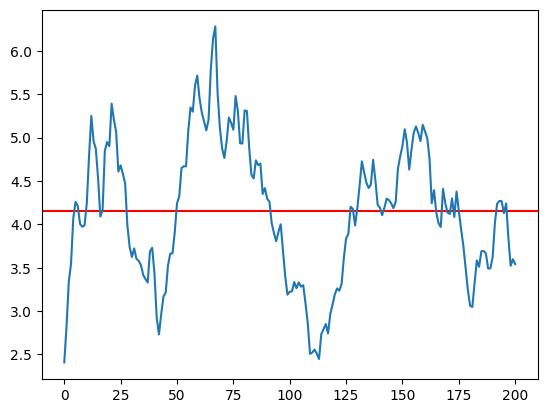

In [10]:
fig, ax = plt.subplots()

ax.axhline(y=np.mean(prec_over_time), color = 'r')
ax.plot(prec_over_time)

In [11]:
## TODO : better put the null values to nan so that they don't interfere when looking at mean (np.nanmean)
#prec_shape = np.shape(prec)
#prec_no_null = prec[np.where(prec!=0)].reshape(prec_shape)
#print(np.shape(prec_no_null))
#prec_no_null_over_time = np.mean(prec_no_null[:], axis = (1,2))
#prec_no_null_over_xy = np.mean(prec_no_null, axis = (0))


In [12]:
intense_idx = [i for i in range(len(prec_over_time)) if prec_over_time[i]>np.mean(prec_over_time)]
calm_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]

print(intense_idx)


[5, 6, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 168, 169, 172, 174, 175, 192, 193, 194, 196]


In [13]:
high_prec_timestop = [(10,28), (50,92), (127, 175)]
low_prec_timestop = [(0,10), (28,50), (92, 127), (175,200)]
high_rain_idx = [i for i in range(10, 28)] + [i for i in range(50, 92)] + [i for i in range(127, 175)]
low_rain_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]
low_prec = prec_over_time[low_rain_idx]
high_prec = prec_over_time[high_rain_idx]

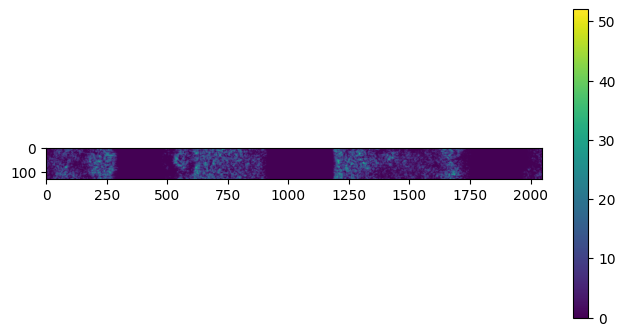

In [14]:
fig = plt.figure(figsize = (8,4))
plt.imshow(prec_over_xy, cmap='viridis')
plt.colorbar()
plt.show()

In [15]:
data_high = []
data_low = []

for t in high_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    or_len = len(nc_t)
    nc_t = nc_t[np.where(nc_t!=0)]
    data_high.append(nc_t)
    fin_len = len(nc_t)
    print(f"0 represented {1-(fin_len/or_len)}% of our datasets, now we have {fin_len} points")

for t in low_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    nc_t = nc_t[np.where(nc_t!=0)]
    data_low.append(nc_t)  

0 represented 0.8951299455430772% of our datasets, now we have 494839 points
0 represented 0.9045186723981585% of our datasets, now we have 1051254 points
0 represented 0.9042143026987711% of our datasets, now we have 1205263 points


In [16]:
dist_linear = cs.Distribution(name = 'high 0', nbins =40)
dist_linear.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))
print(len(dist_linear.bins))

41


Text(0, 0.5, 'Cumulative density (CDF)')

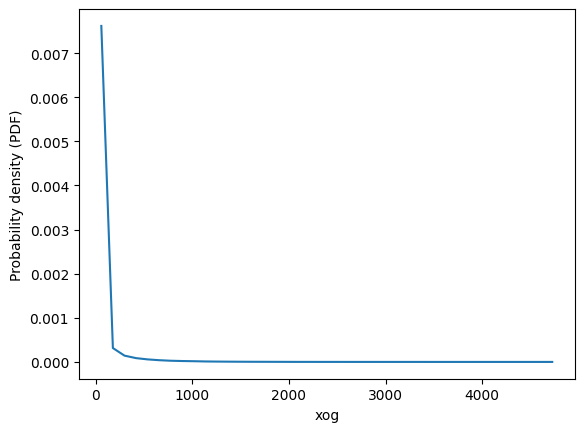

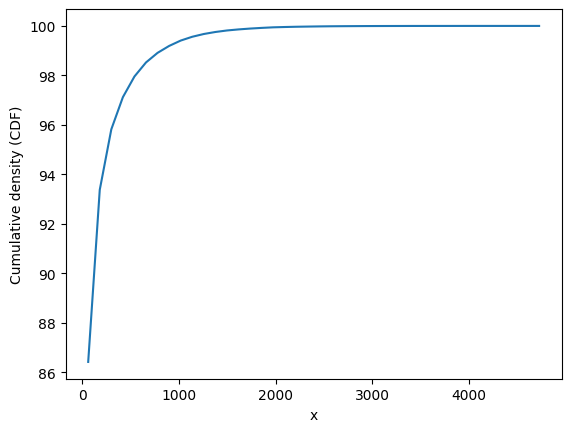

In [17]:
d = dist_linear
plt.plot(d.percentiles,d.density)
plt.xlabel('xog')
plt.ylabel('Probability density (PDF)')
plt.figure()
plt.plot(d.percentiles,d.ranks)
plt.xlabel('x')
plt.ylabel('Cumulative density (CDF)')

In [18]:
dist_log = cs.Distribution(name = 'high 0', nbins = 140, bintype = 'log')
dist_log.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0])+1e-10)

Text(0.5, 0, 'x')

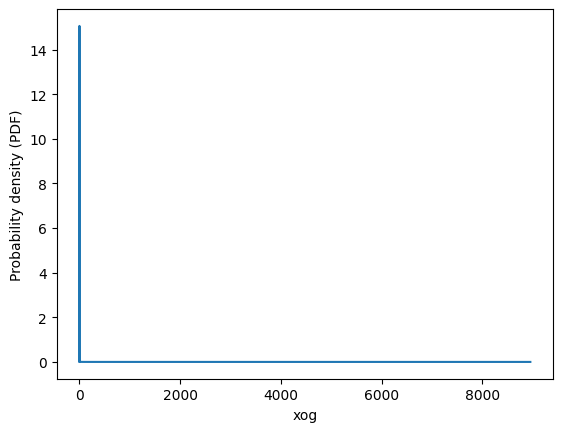

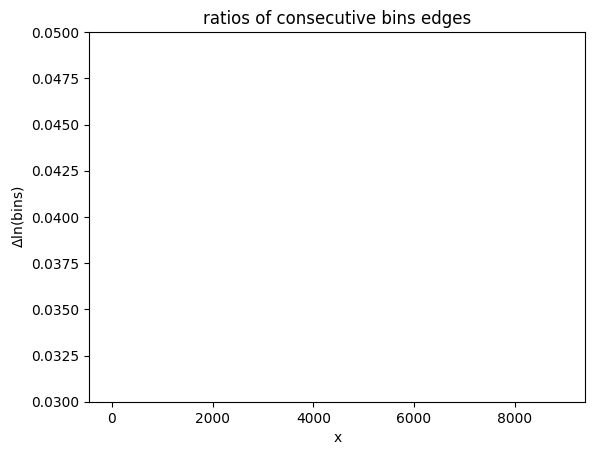

In [19]:
d = dist_log
plt.plot(d.percentiles,d.density)
plt.xlabel('xog')
plt.ylabel('Probability density (PDF)')
plt.figure()

bin_ratios = np.log(d.bins[1:]/d.bins[:-1]) ## Ok j'ai pas compris finalement
plt.plot(d.percentiles,bin_ratios)
# plt.xscale('log')
plt.title('ratios of consecutive bins edges')
plt.ylim((0.03,0.05))
plt.ylabel(r'$\Delta \ln$(bins)')
plt.xlabel('x')

In [20]:
dist_linQ = cs.Distribution(name='x',bintype='linQ')
dist_linQ.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))

Text(0, 0.5, 'Cumulative density (CDF)')

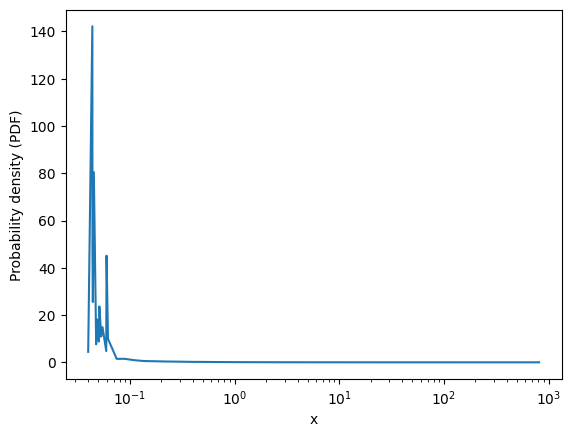

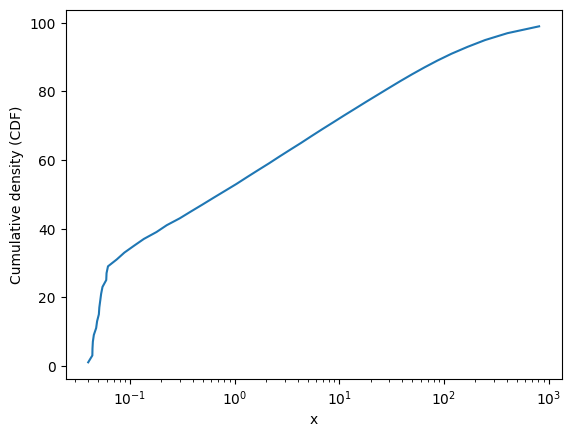

In [21]:
d = dist_linQ
plt.plot(d.percentiles,d.density) ## MJC : Petit souci avec les density qui ne devraient vraiment pas dépasser 1 ? 
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Probability density (PDF)')

plt.figure()
plt.plot(d.percentiles,d.ranks)
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Cumulative density (CDF)')

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys
import netCDF4 as nc
#sys.path.append(os.getcwd()+'/conditional-stats/src/')
sys.path.insert(0, os.getcwd()+'/../conditional-stats/src/')
import conditionalstats as cs

nc_rcemip1 = nc.Dataset("/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_2.nc")

nc1 = nc_rcemip1
prec = nc1["Prec"][:]

##from dataviz
high_prec_timestop = [(10,28), (50,92), (127, 175)]
low_prec_timestop = [(0,10), (28,50), (92, 127), (175,200)]
high_rain_idx = [i for i in range(10, 28)] + [i for i in range(50, 92)] + [i for i in range(127, 175)]
low_rain_idx = [i for i in range(len(prec_over_time)) if i not in intense_idx]
low_prec = prec_over_time[low_rain_idx]
high_prec = prec_over_time[high_rain_idx]


##cleaning data
data_high = []
data_low = []


for t in high_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    or_len = len(nc_t)
    nc_t = nc_t[np.where(nc_t!=0)]
    data_high.append(nc_t)
    fin_len = len(nc_t)
    print(f"0 represented {1-(fin_len/or_len)}% of our datasets, now we have {fin_len} points")

for t in low_prec_timestop:
    start,end = t
    nc_t = nc1["Prec"][start:end, :, : ].flatten()
    nc_t = nc_t[np.where(nc_t!=0)]
    data_low.append(nc_t)  

    

dist_invlogQ = cs.Distribution(name='x',bintype='invlogQ',nd=4,fill_last_decade=True)
dist_invlogQ.computeDistribution(sample = data_high[0], vmax = np.max(data_high[0]), vmin = np.min(data_high[0]))

0 represented 0.8951299455430772% of our datasets, now we have 494839 points
0 represented 0.9045186723981585% of our datasets, now we have 1051254 points
0 represented 0.9042143026987711% of our datasets, now we have 1205263 points


In [23]:
bins = np.array([np.nan]*(42))
sample_no_nan = data_high[0][np.logical_not(np.isnan(data_high[0]))]

rank_edges = [0, 10.283588263785926, 28.735721039776262, 43.392771094626724
 ,55.035279790961525 ,64.28325317148324 ,71.6291795416102, 77.4642562676077
 ,82.09922246285004 ,85.78090697872359 ,88.70537294102917, 91.0283588263786
 ,92.87357210397764 ,94.33927710946267 ,95.50352797909615, 96.42832531714834
 ,97.16291795416103 ,97.74642562676077 ,98.209922246285, 98.57809069787237
 ,98.87053729410292 ,99.10283588263786 ,99.28735721039776, 99.43392771094626
 ,99.55035279790961 ,99.64283253171483 ,99.71629179541611, 99.77464256267608
 ,99.8209922246285 ,99.85780906978724 ,99.8870537294103 ,99.91028358826378
 ,99.92873572103977 ,99.94339277109464 ,99.95503527979096, 99.96428325317149
 ,99.97162917954161 ,99.97746425626761 ,99.98209922246285, 99.98578090697873
 ,99.98870537294103, None]

bins[1:-1] = np.percentile(data_high[0], rank_edges[1:-1])


In [24]:
types = []
for x in data_high[0]:
    types.append(type(x))
    np.isnan(x)

for x in types : 
    if x != np.float32 : print(x) 

In [51]:
from numpy import percentile
import inspect
print(inspect.getsource(percentile))


@array_function_dispatch(_percentile_dispatcher)
def percentile(a,
               q,
               axis=None,
               out=None,
               overwrite_input=False,
               method="linear",
               keepdims=False,
               *,
               interpolation=None):
    """
    Compute the q-th percentile of the data along the specified axis.

    Returns the q-th percentile(s) of the array elements.

    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array.

        .. versionchanged:: 1.9.0
            A tuple of axes is supported
    out : ndarray, optional
      

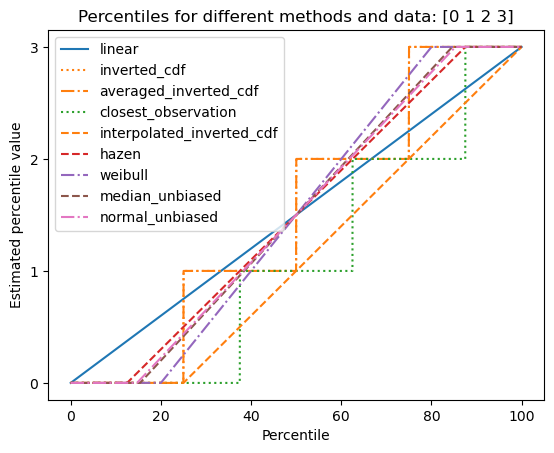

In [52]:
import matplotlib.pyplot as plt

a = np.arange(4)
p = np.linspace(0, 100, 6001)
ax = plt.gca()
lines = [
    ('linear', '-', 'C0'),
    ('inverted_cdf', ':', 'C1'),
    # Almost the same as `inverted_cdf`:
    ('averaged_inverted_cdf', '-.', 'C1'),
    ('closest_observation', ':', 'C2'),
    ('interpolated_inverted_cdf', '--', 'C1'),
    ('hazen', '--', 'C3'),
    ('weibull', '-.', 'C4'),
    ('median_unbiased', '--', 'C5'),
    ('normal_unbiased', '-.', 'C6'),
    ]
for method, style, color in lines:
    ax.plot(
        p, np.percentile(a, p, method=method),
        label=method, linestyle=style, color=color)
ax.set(
    title='Percentiles for different methods and data: ' + str(a),
    xlabel='Percentile',
    ylabel='Estimated percentile value',
    yticks=a)
ax.legend()
plt.show()

In [53]:
percentile??


Signature:
percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    method='linear',
    keepdims=False,
    *,
    interpolation=None,
)
Source:   
@array_function_dispatch(_percentile_dispatcher)
def percentile(a,
               q,
               axis=None,
               out=None,
               overwrite_input=False,
               method="linear",
               keepdims=False,
               *,
               interpolation=None):
    """
    Compute the q-th percentile of the data along the specified axis.

    Returns the q-th percentile(s) of the array elements.

    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to comput